[View in Colaboratory](https://colab.research.google.com/github/kentaojapi/dataanalysis_tgs-salt/blob/master/20181002_4_kaggle_salt.ipynb)

In [0]:
# download API key from google drive
## Original: https://colab.research.google.com/drive/1eufc8aNCdjHbrBhuy7M7X6BGyzAyRbrF#scrollTo=y5_288BYp6H1
## When you run for the first time, you will see a link to authenticate.

from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [0]:
!ls

adc.json  sample_data


In [0]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c tgs-salt-identification-challenge
!unzip train.zip
!mv images/ train/
!unzip test.zip
!mv images/ test/
!rm train.zip
!rm test.zip
!df -h
from IPython.display import clear_output
clear_output()

In [0]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange, trange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, Activation, MaxPooling2D, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.optimizers import Adam, SGD
from keras import losses
from keras.preprocessing import image

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from google.colab import files

from jinja2 import Template

Using TensorFlow backend.


In [0]:
im_width = 128
im_height = 128
im_chan = 1
path_train = '../content/train/'
path_test = '../content/test/'

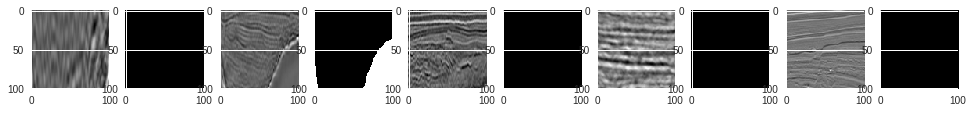

In [0]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('../content/train/' + img_name + '.png')
    img_mask = load_img('../content/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [0]:
df_depth = pd.read_csv('../content/depths.csv')

train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]

df_train_depth = df_depth.query('id in {0}'.format(list(map(lambda x: x.split('.')[0], train_ids))))
df_train_depth = df_train_depth.sort_values(by=['z']).reset_index(drop=True)

df_test_depth = df_depth.query('id in {0}'.format(list(map(lambda x: x.split('.')[0], test_ids))))
df_test_depth = df_test_depth.sort_values(by=['z']).reset_index(drop=True)

In [0]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.uint8)

print('Getting and resizing train images and masks ...')
sys.stdout.flush()

for n, id_ in enumerate(train_ids):
    img = load_img(path_train + id_)
    x = img_to_array(img)[:, :, 1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    
    mask = img_to_array(load_img('../content/masks/' + id_))[:, :, 1]
    y = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)
    y_train[n] = y
    
print('Done')

Getting and resizing train images and masks ...
Done


In [0]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in enumerate(test_ids):
    img = load_img(path_test + id_)
    x = img_to_array(img)[:, :, 1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 
Done!


In [0]:
print("X_train.shape : ", X_train.shape)
print("X_test.shape : ", X_test.shape)

X_train.shape :  (4000, 128, 128, 1)
X_test.shape :  (18000, 128, 128, 1)


In [0]:
# reshape train(4000, 128, 128, 1) to (4000, )
X_train_norm = X_train.reshape(4000, 128*128).sum(axis=1) / 255
y_train_norm = y_train.reshape(4000, 128*128).sum(axis=1) / 255

df_train_salt_norm = pd.DataFrame({
    'img': X_train_norm,
    'mask': y_train_norm,
    'depth': df_train_depth.z,
    'id': df_train_depth.id
})

# reshape test(18000, 128, 128, 1) to (18000, ) 
X_test_norm = X_test.reshape(18000, 128*128).sum(axis=1) / 255
df_test_salt_norm = pd.DataFrame({
    'img': X_test_norm,
    'depth': df_test_depth.z,
    'id': df_test_depth.id
})

In [0]:
df_train_salt_norm.head()

,depth,id,img,mask
0,51,d0244d6c38,7906.835294,4223.258824
1,53,a31e485287,8721.086275,4763.058824
2,54,ad2113ea1c,8052.823529,0.000000
3,54,5aa0015d15,8208.741176,0.000000
4,55,a3e0a0c779,8099.411765,4591.341176


Text(0.5,1,'depth mask')

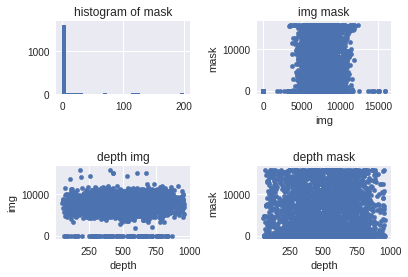

In [0]:
fig , ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace=1, wspace=0.5)

df_train_salt_norm.query('mask < 200')['mask'].hist(bins=30, ax=ax[0][0])
ax[0][0].set_title('histogram of mask' )

df_train_salt_norm.plot(kind='scatter', x='img', y='mask', ax=ax[0][1])
ax[0][1].set_title('img mask')

df_train_salt_norm.plot(kind='scatter', x='depth', y='img', ax=ax[1][0])
ax[1][0].set_title('depth img')

df_train_salt_norm.plot(kind='scatter', x='depth', y='mask', ax=ax[1][1])
ax[1][1].set_title('depth mask')

Text(0.5,1,'[Test] histgram of depth')

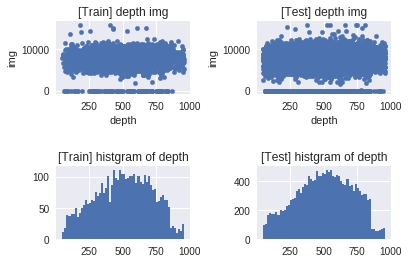

In [0]:
fig , ax = plt.subplots(nrows=2, ncols=2)
plt.subplots_adjust(hspace=1, wspace=0.5)

df_train_salt_norm.plot(kind='scatter', x='depth', y='img', ax=ax[0][0])
ax[0][0].set_title('[Train] depth img')

df_test_salt_norm.plot(kind='scatter', x='depth', y='img', ax=ax[0][1])
ax[0][1].set_title('[Test] depth img')

df_train_salt_norm.depth.hist(bins=60, ax=ax[1][0])
ax[1][0].set_title('[Train] histgram of depth')

df_test_salt_norm.depth.hist(bins=60, ax=ax[1][1])
ax[1][1].set_title('[Test] histgram of depth')

0 d0244d6c38 51


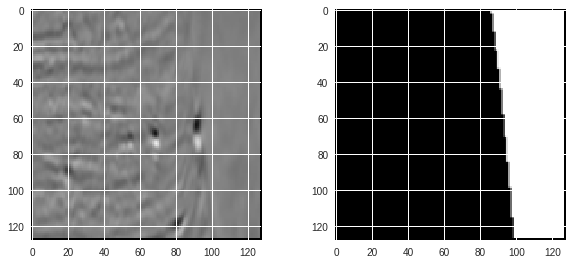

1 a31e485287 53


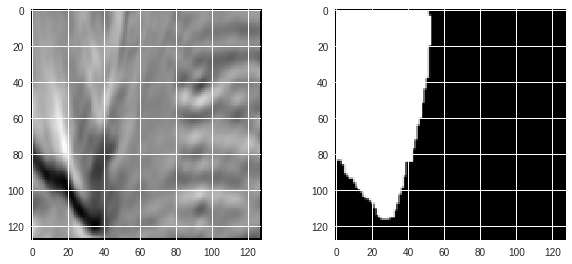

2 ad2113ea1c 54


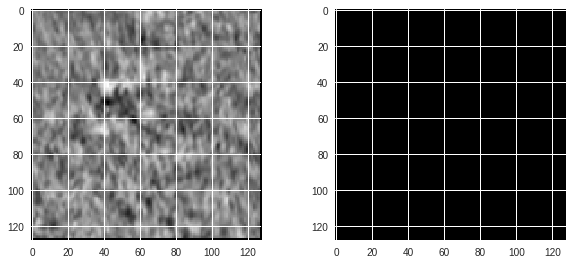

3 5aa0015d15 54


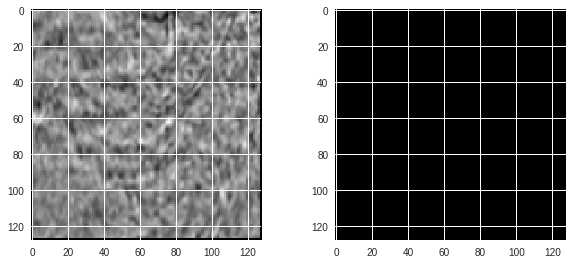

4 a3e0a0c779 55


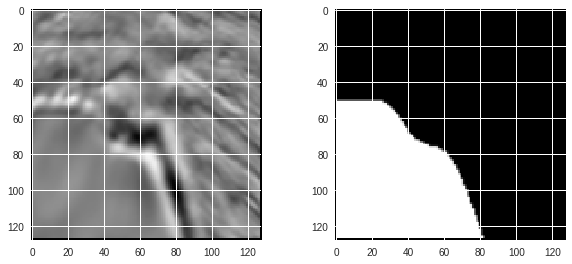

5 b11110b854 55


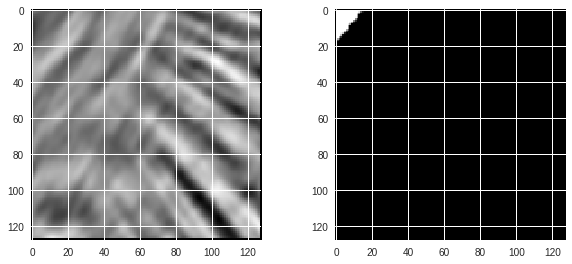

6 6f79e6d54b 58


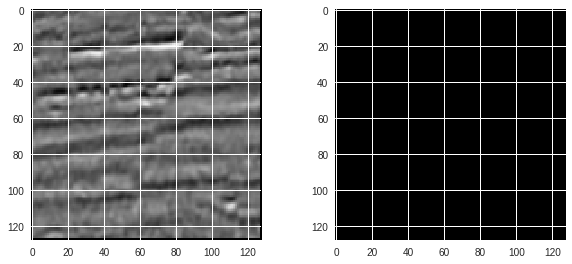

7 0b9981aba1 59


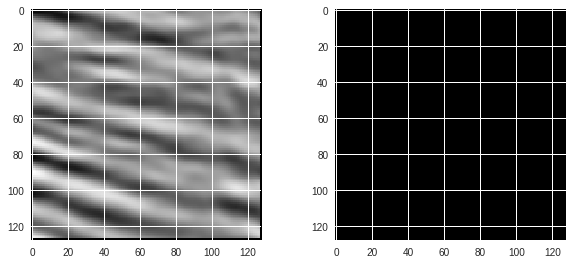

8 eab589e1f2 63


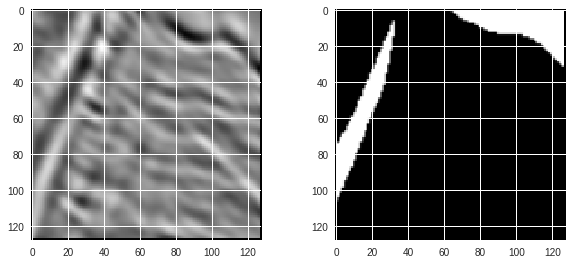

9 dc534f1e28 63


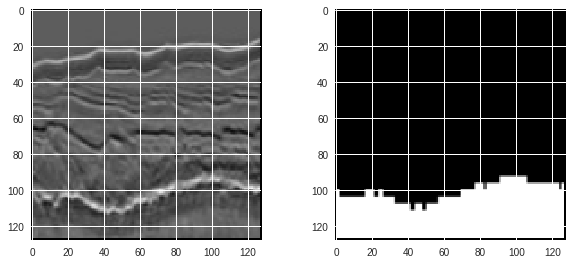

In [0]:
begin = 0
show_num = 10

for n, ix in enumerate(range(begin, show_num)):
  plt.figure(figsize=(10, show_num*5))
  print(ix, df_train_depth.iloc[ix].id, df_train_depth.iloc[ix].z)
  
  plt.subplot(show_num, 2, n * 2 + 1)
  plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))

  plt.subplot(show_num, 2, n * 2 + 2)
  tmp = np.squeeze(y_train[ix]).astype(np.float32)/255.0
  plt.imshow(np.dstack((tmp,tmp,tmp)))
  plt.show()


In [0]:
def rotate_img(x, theta, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = image.transform_matrix_offset_center(rotation_matrix, h, w)
    x = image.apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.pi / 180 * np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = rotate(img, theta)
        mask = rotate(mask, theta)
    return img, mask
  
def flip_img(x, flip_number):
    return cv2.flip(x, flip_number)

In [0]:
#rotate = 90.0
#theta = np.pi / 180.0 * rotate
#print('theta %.2f' % theta)

img_flips = np.zeros((len(X_train), im_height, im_width, im_chan), dtype=np.uint8)
mask_flips = np.zeros((len(y_train), im_height, im_width, 1), dtype=np.uint8)

for i in range(len(X_train)):
    img_flip = flip_img(X_train[i], 0)
    mask_flip = flip_img(y_train[i], 0)

    img_flips[i] = img_flip.reshape(im_width, im_height, im_chan)
    mask_flips[i] = mask_flip.reshape(im_width, im_height, 1)

In [0]:
X_train = np.vstack((X_train, img_flips))
y_train = np.vstack((y_train, mask_flips))

print('the length of combined X_train : ', len(X_train))
print('the length of combined y_train: ', len(y_train))

the length of combined X_train :  8000
the length of combined y_train:  8000


In [0]:
X_train_norm = X_train / 255.0
y_train_norm = y_train / 255.0

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)
  
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score
  
def iou_bce_loss(y_true, y_pred):
    return 0.5 * losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((im_width, im_height, 1))
output_layer = build_model(input_layer, 16)

In [0]:
optimizer = SGD(lr=0.01)

model = Model(input_layer, output_layer)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy', mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dropout_1 

In [0]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
save_file = 'model-tgs-salt-1-{}.h5'.format(now)

earlystopper = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=5, verbose=1)
checkpointer = ModelCheckpoint(save_file, verbose=1, save_best_only=True)

epochs = 200
batch_size=32

results = model.fit(
    X_train_norm, 
    y_train_norm, 
    batch_size=batch_size, 
    validation_split=0.2, 
    epochs=epochs, 
    callbacks=[earlystopper, checkpointer]
)

#results = model.fit(X_train_norm, y_train_norm, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])
#results = model.fit(X_train_norm, y_train_norm, validation_split=0.1, batch_size=8, epochs=30)

Train on 6400 samples, validate on 1600 samples
Epoch 1/200
6400/6400 [==============================] - 55s 9ms/step - loss: 0.2729 - acc: 0.8963 - mean_iou: 0.7144 - val_loss: 0.3779 - val_acc: 0.8528 - val_mean_iou: 0.7093

Epoch 00001: val_loss improved from inf to 0.37791, saving model to model-tgs-salt-1-20181003011008.h5
Epoch 2/200
6400/6400 [==============================] - 51s 8ms/step - loss: 0.2723 - acc: 0.8959 - mean_iou: 0.7063 - val_loss: 0.3393 - val_acc: 0.8709 - val_mean_iou: 0.7092

Epoch 00002: val_loss improved from 0.37791 to 0.33932, saving model to model-tgs-salt-1-20181003011008.h5
Epoch 3/200
6400/6400 [==============================] - 51s 8ms/step - loss: 0.2721 - acc: 0.8963 - mean_iou: 0.7100 - val_loss: 0.2843 - val_acc: 0.8902 - val_mean_iou: 0.7103

Epoch 00003: val_loss improved from 0.33932 to 0.28429, saving model to model-tgs-salt-1-20181003011008.h5
Epoch 4/200
6400/6400 [==============================] - 51s 8ms/step - loss: 0.2679 - acc: 0.8977

In [0]:
from google.colab import drive
drive.mount('/content/drive')
model.save("drive/My Drive/kaggle/{}".format(save_file))

Mounted at /content/drive


In [0]:
from google.colab import drive
drive.mount('/content/drive')
model = load_model("drive/My Drive/kaggle/model-tgs-salt-1-20181002231046.h5",
                  custom_objects={'mean_iou': mean_iou})

Mounted at /content/drive


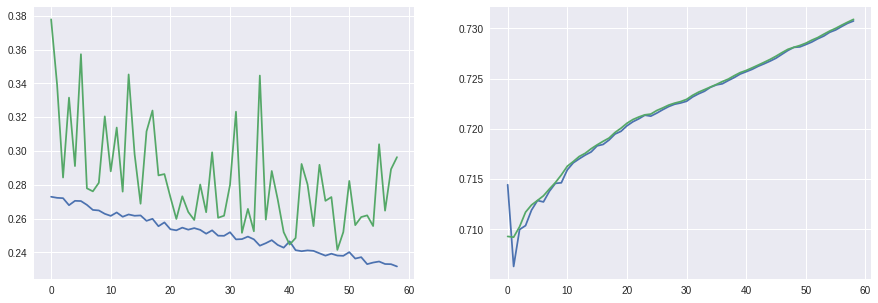

In [0]:
history = results
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation accuracy")

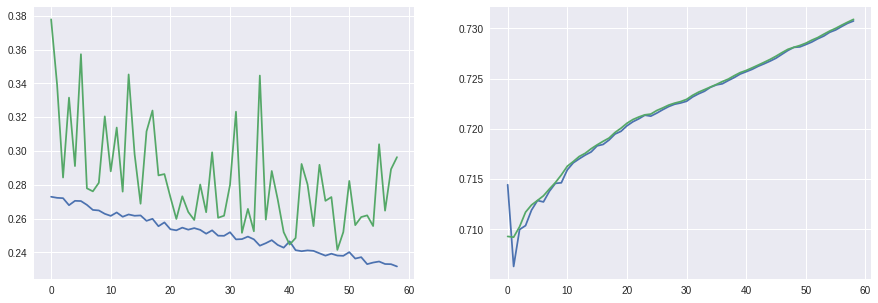

In [0]:
history = results
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mean_iou"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_mean_iou"], label="Validation accuracy")

In [0]:
X_test_norm = X_test / 255.0

preds_train = model.predict(X_train_norm[:int(X_train_norm.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train_norm[int(X_train_norm.shape[0]*0.8):], verbose=1)
preds_test = model.predict(X_test_norm, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - 38s 2ms/step


In [0]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [0]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in enumerate(test_ids)}

In [0]:
import datetime
now = datetime.datetime.now().strftime('%Y%m%d%H%m%S')
submit_name = 'submission_{}.csv'.format(now)

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submit_name)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
!cp "../content/$submit_name" "drive/My Drive/kaggle/"
!kaggle competitions submit -c tgs-salt-identification-challenge -f "drive/My Drive/kaggle/$submit_name" -m "$now"

Successfully submitted to TGS Salt Identification Challenge